In [3]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

from Dino_Images import *

import pandas as pd
import numpy as np
import os

In [10]:


def find_sequence(rotations, translations):
    # assuming len(rotations) == len(translations)
    remaining = [i for i in range(1, len(rotations))]
    
    current_order = [0]
    
    # super slow method, prob betters
    while len(remaining) > 0:
#         print(remaining)
        curr_index = current_order[-1]
        curr_translation = translations[curr_index]
        
        closest_index = remaining[0]
        diff = np.sum(np.square(curr_translation - translations[closest_index]))
        for j in range(1, len(remaining)):
            test_index = remaining[j]
            
#             test_rotation = rotations[test_index]
            test_translation = translations[test_index]
            test_diff = np.sum(np.square(test_translation - curr_translation))
            if test_diff < diff:
                closest_index = test_index
                diff = test_diff
        remaining.remove(closest_index)
        current_order.append(closest_index)
    return current_order
    
dino = Dino_Images()

order = find_sequence(dino.R_Matrix, dino.T_Matrix)
print(order)


[0, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [2]:
def get_parameters(dino_param_df):
    """
    Read the text file to get the parmeters of interest: K, R, T
    """

    param_dict = {}

    for i in range(len(dino_param_df)):
        row = dino_param_df.loc[i]
        K = np.array(row.loc[1:9].tolist()).reshape(3,3)
        R = np.array(row.loc[10:18].tolist()).reshape(3,3)
        T = np.array(row.loc[19:].tolist()).reshape(3,1)

        # param_dict[dino_param_df.loc[i][0]] = [K, R, T]
        param_dict[i] = [K, R, T]
    
    return param_dict


def get_translation_matrix(T):
    """
    T_mat = [ 0  -a3 a2]
            [ a3  0 -a2]
            [-a2 a1  0 ]
    """
    a1, a2, a3 = T

    T_mat = np.zeros((3,3))
    T_mat[0, 1] = -a3
    T_mat[0, 2] = a2
    T_mat[1, 0] = a3
    T_mat[1, 2] = -a2
    T_mat[2, 0] = -a2
    T_mat[2, 1] = a1

    return T_mat


def get_E_matrix(T, R):
    """
    E = [T]_x R
    """

    T_cross = get_translation_matrix(T)

    E_mat = T_cross @ R

    return E_mat

def get_F_matrix(K, E):
    """
    F = K^-T E K^T
    """

    F_mat = np.linalg.inv(K.T) @ E @ K.T

    return F_mat

In [3]:
# Read the original text file
path_to_dino_imgs = os.path.join(os.getcwd(), 'dinoSparseRing', 'dinoSR_par.txt')

dino_param_df = pd.read_table(path_to_dino_imgs, header=None, skiprows=[0], delim_whitespace=True)

In [4]:
# Reorganize the params
dino_params = get_parameters(dino_param_df=dino_param_df)

## Start with only two camera centers

In [5]:
C1_params = dino_params[0]
C2_params = dino_params[1]

In [6]:
# Calculate the Essential Matrix
    # Ci_params =  [K, R, T]

K1, R1, T1 = C1_params
K2, R2, T2 = C2_params

R_rel = np.linalg.inv(R1) @ R2
T_rel = T2 - T1

E = get_E_matrix(T = T_rel, R = R_rel)
# Calculate the Fundamental Matrix using K^-T E K^T

F = get_F_matrix(K = R_rel, E = E)

F

array([[ 0.00059732,  0.01108194, -0.00189644],
       [-0.0137689 , -0.0003169 ,  0.00215244],
       [ 0.00211997, -0.00908169,  0.00080979]])

In [7]:
def get_bound_box_intensities(im, point, bounding_box_size):

    i = bounding_box_size//2
    u,v = point[0], point[1]
    if (type(u) == int) and (type(v) == int):
        l_min, l_max = u - i, u + i
        r_min, r_max = v - i, v + i

        #bb_int = im[l_min:(l_max+1), r_min:(r_max+1), :]
    else:
        if (type(u) == int):
            v_lower = int(np.floor(v))
            v_higher = int(np.ceil(v))

            l_min, l_max = int(u - i), int(u + i)
            r_min_lower, r_max_lower = v_lower - i, v_lower + i
            r_min_higher, r_max_higher = v_higher - i, v_higher + i

            bb_int_list = [im[l_min:(l_max+1), r_min_lower:(r_max_lower+1), :], \
                            im[l_min:(l_max+1), r_min_higher:(r_max_higher+1), :]]
                            
            # if np.argmax(bb_int_list) == 0:
            #     r_min, r_max = r_min_lower, r_max_lower
            #     v = v_lower
            # else:
            #     r_min, r_max = r_min_higher, r_max_higher
            #     v = v_higher
            
            return bb_int_list, v_lower, v_higher

        else:
            u_lower = int(np.floor(u))
            u_higher = int(np.ceil(u))

            r_min, r_max = int(v - i), int(v + i)
            l_min_lower, l_max_lower = u_lower - i, u_lower + i
            l_min_higher, l_max_higher = u_higher - i, u_higher + i

            bb_int_list = [im[l_min_lower:(l_max_lower+1), r_min:(r_max+1), :], \
                            im[l_min_higher:(l_max_higher+1), r_min:(r_max+1), :]]
            
            # if np.argmax(bb_int_list) == 0:
            #     l_min, l_max = l_min_lower, l_max_lower
            #     u = u_lower
            # else:
            #     l_min, l_max = l_min_higher, l_max_higher
            #     u = u_higher
            
            return bb_int_list, u_lower, u_higher


def loss_function(image_point, image_point_2, bb_int_L, bb_int_R):

    # Photoconsistency (?) + (Positional Consistency)
    loss = np.sum(np.square(bb_int_L - bb_int_R)) + np.sum(np.abs(image_point - image_point_2))

    return loss

def get_match_points(imL, imR, x1, F, bounding_box_size):

    # Define some common variables:
    l,w,c = np.shape(imL)

    final_R_points_list = []
    epipolar_line_L_list, epipolar_line_R_list = [], []
    u, v = np.arange(l-1), np.arange(w-1)
    
    for i in range(len(x1)):

        # (u,v) of interest
        image_point = np.array([x1[i, 0], x1[i, 1]])
        # (u,v,1)
        image_point_homo = np.hstack([image_point, 1])
        # Current l1 = Fx
        l1 = np.dot(F, image_point_homo.T)
        
        # Calculate all possible points on epipolar line
        u_pt_on_l1_not_int = -(1/l1[0])*(v*l1[1]+l1[2])
        
        # Indices of the second image
        x2_on_eline = np.vstack([u_pt_on_l1_not_int, v]).T
        # # Location out NOT out of bounds
        x2_on_eline = x2_on_eline[np.where((x2_on_eline[:, 0] < l - bounding_box_size) & \
                                     (x2_on_eline[:, 0] > bounding_box_size) & \
                                     (x2_on_eline[:, 1] < w - bounding_box_size) & \
                                     (x2_on_eline[:, 1] > bounding_box_size))]
        
        # Which point on the second image corresponds to image_point:
        # Epipolar line on the second image
        epipolar_line_R_list.append([u_pt_on_l1_not_int, v])
        
        bb_int_L, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)

        final_loss_list = []
        final_image_point_2_list = []
        
        for i in range(len(x2_on_eline)):
            # Testing if current point on epipolar line in image 2 works
            image_point_2 = x2_on_eline[i, :]
            
            # Return the (bounding_box_size x bounding_box_size x 3)
            bb_int_R_list, u_lower, u_higher = get_bound_box_intensities(imR, image_point_2, bounding_box_size)            

            # Custom loss functino
            image_point_2_list= [np.array([u_lower, image_point_2[1]]), np.array([u_higher, image_point_2[1]])]
            
            # bb_int_L[0] = bb_int_L[1] since the image_point are all ints to begin with
            loss_list = [loss_function(bb_int_L, bb_int_R_list[0], image_point, image_point_2_list[0]), \
                            loss_function(bb_int_L, bb_int_R_list[1], image_point, image_point_2_list[1])]

            loss_arg = np.argmin(loss_list)
            
            image_point_2 = image_point_2_list[loss_arg]
            loss = loss_list[loss_arg]
            
            final_image_point_2_list.append(image_point_2)
            final_loss_list.append(loss)

        
        final_R_point = final_image_point_2_list[np.argmin(final_loss_list)]
        
        image_point_2_homo = np.hstack([final_R_point, 1])

        l2 = np.dot(image_point_2_homo.T, F)

        v_pt_on_l2_not_int = -(1/l2[1])*(u*l2[0]+l2[2])

        epipolar_line_L_list.append([u, v_pt_on_l2_not_int])
        final_R_points_list.append(final_R_point)

    
    final_R_points = np.array(final_R_points_list)
    epipolar_line_L, epipolar_line_R = np.array(epipolar_line_L_list), np.array(epipolar_line_R_list)

    return final_R_points, epipolar_line_L, epipolar_line_R

# R_points, e_L, e_R = get_match_points(imL, imR, x1, F, 5)


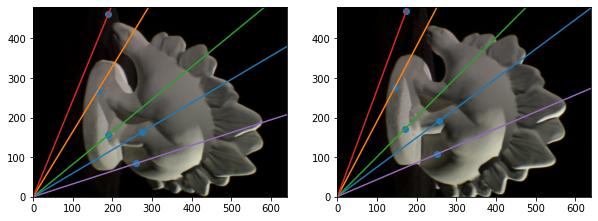

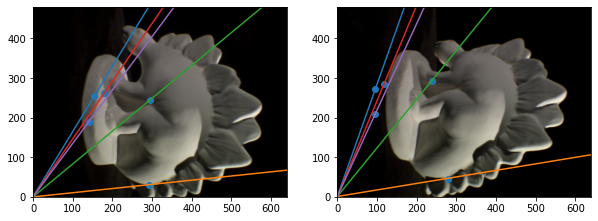

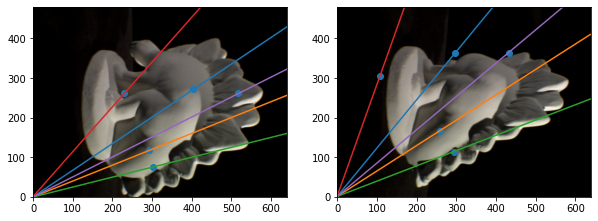

ValueError: attempt to get argmin of an empty sequence

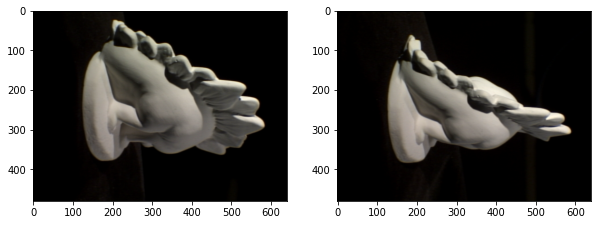

In [19]:
# Test using two images:
    # - WHEN THINGS WORKS, USE THIS CODE CHUNK TO RUN THROUGH ALL THE IMAGES

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)




# Read the original text file
path_to_dino_imgs = os.path.join(os.getcwd(), 'dinoSparseRing', 'dinoSR_par.txt')

dino_param_df = pd.read_table(path_to_dino_imgs, header=None, skiprows=[0], delim_whitespace=True)

# Reorganize the params

dino_params = get_parameters(dino_param_df=dino_param_df)

plot=True
# look up num images later
num_images = 10
for i in range(num_images):

#     i = 0 

    C1_params = dino_params[i]
    C2_params = dino_params[i+1]

    # Calculate the Essential Matrix
        # Ci_params =  [K, R, T]

    K1, R1, T1 = C1_params
    K2, R2, T2 = C2_params

    R_rel = np.linalg.inv(R1) @ R2
    T_rel = T2 - T1

    E = get_E_matrix(T = T_rel, R = R_rel)
    # Calculate the Fundamental Matrix using K^-T E K^T

    F = get_F_matrix(K = R_rel, E = E)

    # always use consecutive images for now
    imL = dino.image_list[i]
    imR = dino.image_list[i+1]

    # imL = image.imread("dinoSparseRing/dinoSR0001.png")
    # imR = image.imread("dinoSparseRing/dinoSR0002.png")

    imLgray = rgb2gray(imL)
    imRgray = rgb2gray(imR)

    if plot:
        plt.figure(0,figsize = (10, 4))
        ax81 = plt.subplot(121)
        plt.imshow(imL)
        ax82 = plt.subplot(122)
        plt.imshow(imR)

    # SAMPLE RANDOM INDICES

    # are all the images the same size?
    l,w,c = np.shape(image.imread("dinoSparseRing/dinoSR0001.png"))

    # Keep this an odd number to make things easier
    bounding_box_size = 10
    num_feature_points = 5

    mask = np.where(np.sum(imL, axis = 2) > 0.15, 1, 0)
    points = np.array(np.where(mask == 1)).T

    idx = np.random.choice(np.arange(points.shape[0]), size = num_feature_points)

    x1 = points[idx]

    R_points, e_L, e_R = get_match_points(imL, imR, x1, F, 10)

    if plot:
        plt.figure(0,figsize = (10, 4))
        ax81 = plt.subplot(121)
        plt.imshow(imL)
        plt.scatter(x1[:, 1], x1[:, 0])
        for i in range(len(e_L)):
            plt.plot(e_L[i][1], e_L[i][0])
        plt.xlim(0, w)
        plt.ylim(0, l)
        ax82 = plt.subplot(122)
        plt.imshow(imR)
        plt.scatter(R_points[:, 1], R_points[:, 0])
        for i in range(len(e_R)):
            plt.plot(e_R[i][1], e_R[i][0])
        plt.xlim(0, w)
        plt.ylim(0, l)
        plt.show()


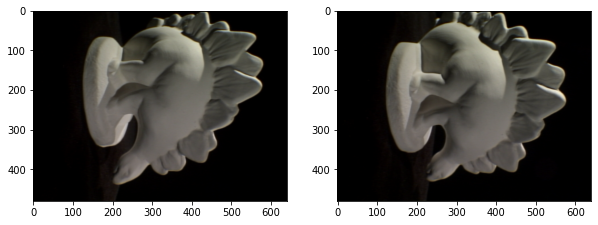

In [9]:
# Test using two images:
    # - WHEN THINGS WORKS, USE THIS CODE CHUNK TO RUN THROUGH ALL THE IMAGES

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("dinoSparseRing/dinoSR0001.png")
imR = image.imread("dinoSparseRing/dinoSR0002.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()